In [1]:
from time import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, pipeline, svm
from sklearn.decomposition import PCA
from sklearn.kernel_approximation import Nystroem, RBFSampler

digits = datasets.load_digits(n_class=9)

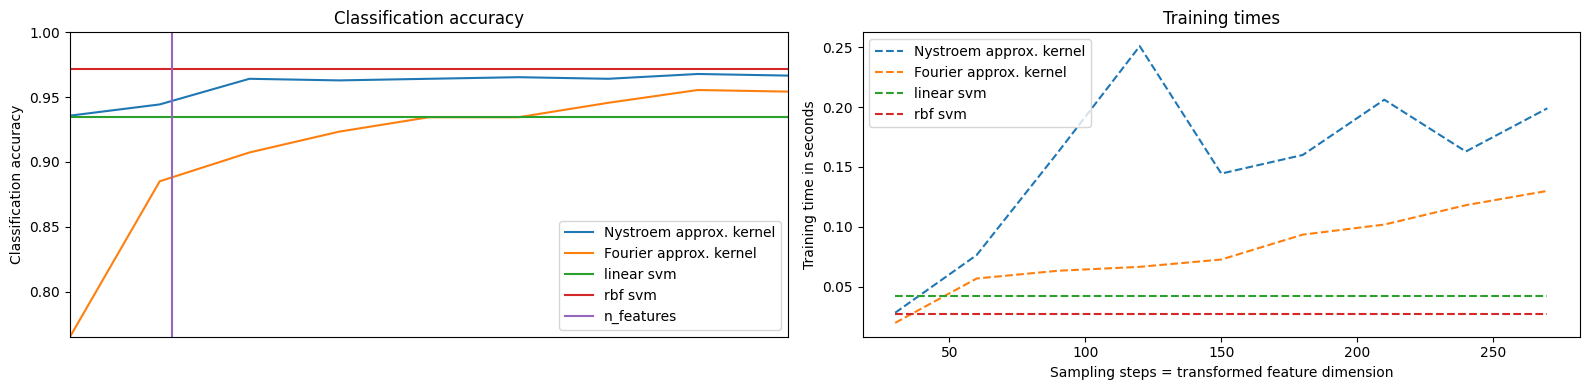

In [2]:
# 9개 클래스의 숫자 데이터셋을 로드합니다.
n_samples = len(digits.data)
data = digits.data / 16.0
data -= data.mean(axis=0)

data_train, targets_train = (data[: n_samples // 2], digits.target[: n_samples // 2])

data_test, targets_test = (data[n_samples // 2 :], digits.target[n_samples // 2 :])

# 여러 SVM 분류기를 생성합니다: 커널 SVM, 선형 SVM, 그리고 커널 근사를 사용한 SVM 두 가지입니다.
kernel_svm = svm.SVC(gamma=0.2)
linear_svm = svm.LinearSVC(dual="auto", random_state=42)

feature_map_fourier = RBFSampler(gamma=0.2, random_state=1)
feature_map_nystroem = Nystroem(gamma=0.2, random_state=1)
fourier_approx_svm = pipeline.Pipeline(
    [
        ("feature_map", feature_map_fourier),
        ("svm", svm.LinearSVC(dual="auto", random_state=42)),
    ]
)

nystroem_approx_svm = pipeline.Pipeline(
    [
        ("feature_map", feature_map_nystroem),
        ("svm", svm.LinearSVC(dual="auto", random_state=42)),
    ]
)


kernel_svm_time = time()
kernel_svm.fit(data_train, targets_train)
kernel_svm_score = kernel_svm.score(data_test, targets_test)
kernel_svm_time = time() - kernel_svm_time

linear_svm_time = time()
linear_svm.fit(data_train, targets_train)
linear_svm_score = linear_svm.score(data_test, targets_test)
linear_svm_time = time() - linear_svm_time

sample_sizes = 30 * np.arange(1, 10)
fourier_scores = []
nystroem_scores = []
fourier_times = []
nystroem_times = []

for D in sample_sizes:
    fourier_approx_svm.set_params(feature_map__n_components=D)
    nystroem_approx_svm.set_params(feature_map__n_components=D)
    start = time()
    nystroem_approx_svm.fit(data_train, targets_train)
    nystroem_times.append(time() - start)

    start = time()
    fourier_approx_svm.fit(data_train, targets_train)
    fourier_times.append(time() - start)

    fourier_score = fourier_approx_svm.score(data_test, targets_test)
    nystroem_score = nystroem_approx_svm.score(data_test, targets_test)
    nystroem_scores.append(nystroem_score)
    fourier_scores.append(fourier_score)

plt.figure(figsize=(16, 4))
accuracy = plt.subplot(121)
timescale = plt.subplot(122)

accuracy.plot(sample_sizes, nystroem_scores, label="Nystroem approx. kernel")
timescale.plot(sample_sizes, nystroem_times, "--", label="Nystroem approx. kernel")

accuracy.plot(sample_sizes, fourier_scores, label="Fourier approx. kernel")
timescale.plot(sample_sizes, fourier_times, "--", label="Fourier approx. kernel")

accuracy.plot(
    [sample_sizes[0], sample_sizes[-1]],
    [linear_svm_score, linear_svm_score],
    label="linear svm",
)
timescale.plot(
    [sample_sizes[0], sample_sizes[-1]],
    [linear_svm_time, linear_svm_time],
    "--",
    label="linear svm",
)

accuracy.plot(
    [sample_sizes[0], sample_sizes[-1]],
    [kernel_svm_score, kernel_svm_score],
    label="rbf svm",
)
timescale.plot(
    [sample_sizes[0], sample_sizes[-1]],
    [kernel_svm_time, kernel_svm_time],
    "--",
    label="rbf svm",
)

accuracy.plot([64, 64], [0.7, 1], label="n_features")

accuracy.set_title("Classification accuracy")
timescale.set_title("Training times")
accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_xticks(())
accuracy.set_ylim(np.min(fourier_scores), 1)
timescale.set_xlabel("Sampling steps = transformed feature dimension")
accuracy.set_ylabel("Classification accuracy")
timescale.set_ylabel("Training time in seconds")
accuracy.legend(loc="best")
timescale.legend(loc="best")
plt.tight_layout()
plt.show()

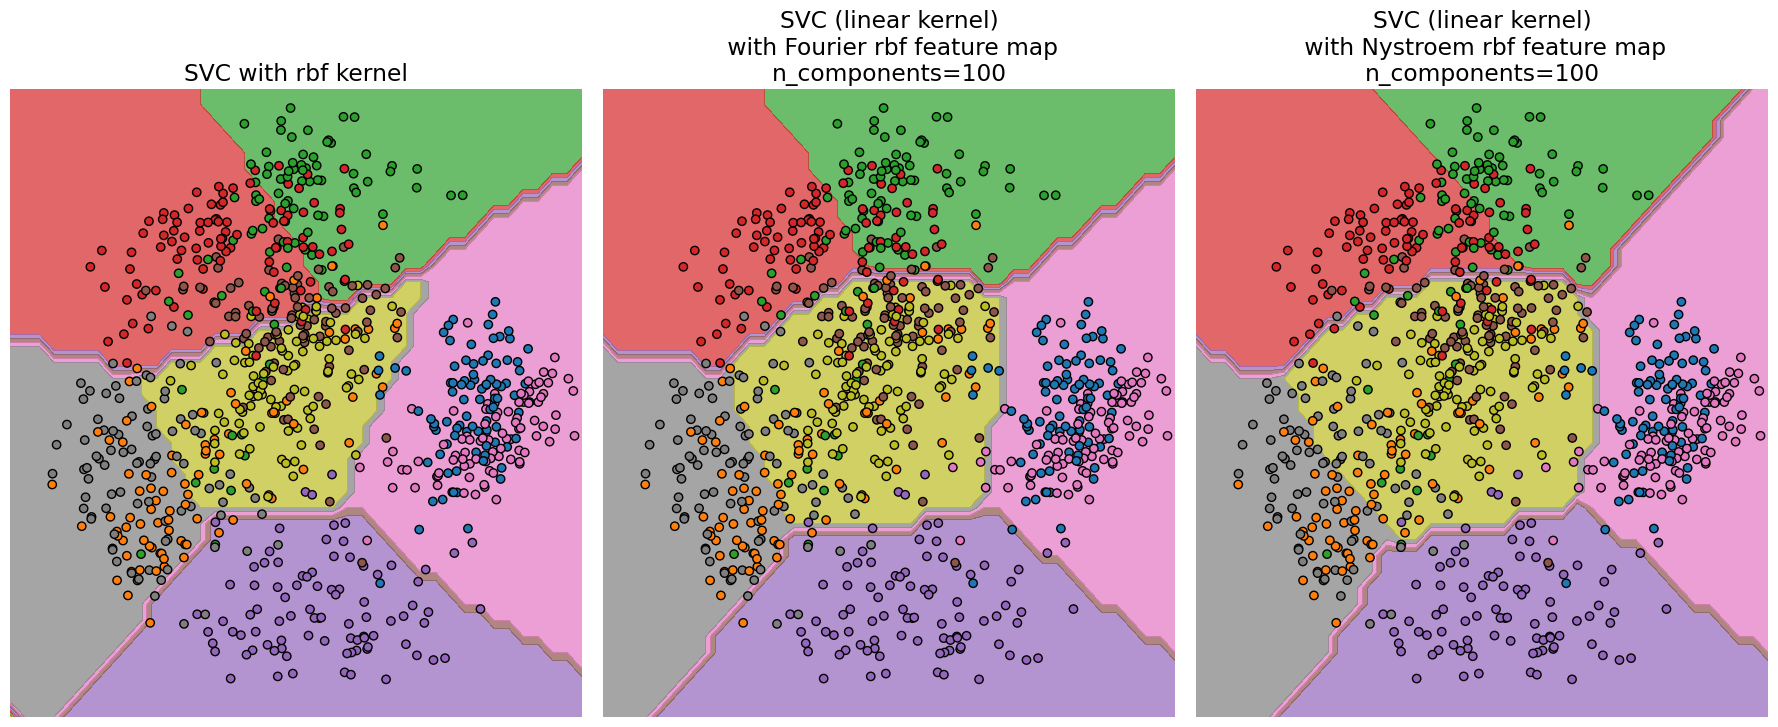

In [3]:
# visualize the decision surface, projected down to the first
# two principal components of the dataset
pca = PCA(n_components=8, random_state=42).fit(data_train)

X = pca.transform(data_train)

# Generate grid along first two principal components
multiples = np.arange(-2, 2, 0.1)
# steps along first component
first = multiples[:, np.newaxis] * pca.components_[0, :]
# steps along second component
second = multiples[:, np.newaxis] * pca.components_[1, :]
# combine
grid = first[np.newaxis, :, :] + second[:, np.newaxis, :]
flat_grid = grid.reshape(-1, data.shape[1])

# title for the plots
titles = [
    "SVC with rbf kernel",
    "SVC (linear kernel)\n with Fourier rbf feature map\nn_components=100",
    "SVC (linear kernel)\n with Nystroem rbf feature map\nn_components=100",
]

plt.figure(figsize=(18, 7.5))
plt.rcParams.update({"font.size": 14})
# predict and plot
for i, clf in enumerate((kernel_svm, nystroem_approx_svm, fourier_approx_svm)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(1, 3, i + 1)
    Z = clf.predict(flat_grid)

    # Put the result into a color plot
    Z = Z.reshape(grid.shape[:-1])
    levels = np.arange(10)
    lv_eps = 0.01  # Adjust a mapping from calculated contour levels to color.
    plt.contourf(
        multiples,
        multiples,
        Z,
        levels=levels - lv_eps,
        cmap=plt.cm.tab10,
        vmin=0,
        vmax=10,
        alpha=0.7,
    )
    plt.axis("off")

    # Plot also the training points
    plt.scatter(
        X[:, 0],
        X[:, 1],
        c=targets_train,
        cmap=plt.cm.tab10,
        edgecolors=(0, 0, 0),
        vmin=0,
        vmax=10,
    )

    plt.title(titles[i])
plt.tight_layout()
plt.show()